In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from skopt import gp_minimize
from xgboost import XGBRegressor
from skopt.plots import plot_convergence
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Exploratory Analysis

In [2]:
# Import of taining and test data
train = pd.read_csv("dados/train.csv")
test = pd. read_csv("dados/test.csv")
print("Train " + str(train.shape))
print("Test " + str(test.shape))

Train (1092059, 4)
Test (537880, 3)


In [3]:
train.head(15)

,id,user_id,joke_id,Rating
0,31030_110,31030,110,2.750
1,16144_109,16144,109,5.094
2,23098_6,23098,6,-6.438
3,14273_86,14273,86,4.406
4,18419_134,18419,134,9.375
5,5782_14,5782,14,-1.781
6,34059_62,34059,62,6.250
7,1159_9,1159,9,-2.906
8,17736_32,17736,32,-5.750
9,22626_22,22626,22,1.656


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092059 entries, 0 to 1092058
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   id       1092059 non-null  object 
 1   user_id  1092059 non-null  int64  
 2   joke_id  1092059 non-null  int64  
 3   Rating   1092059 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 33.3+ MB


In [5]:
train.describe()

,user_id,joke_id,Rating
count,1.092059e+06,1.092059e+06,1.092059e+06
mean,2.068356e+04,6.402266e+01,1.758394e+00
std,1.183032e+04,4.411652e+01,5.230860e+00
min,1.000000e+00,1.000000e+00,-1.000000e+01
25%,1.041200e+04,2.200000e+01,-1.719000e+00
50%,2.130800e+04,6.200000e+01,2.344000e+00
75%,3.078400e+04,1.040000e+02,5.781000e+00
max,4.086300e+04,1.390000e+02,1.000000e+01


In [6]:
# Cheching uniqueness of data
train.select_dtypes(["int64", "float64", "object"]).nunique().sort_values().to_frame().T

,joke_id,Rating,user_id,id
0,139,641,40863,1092059


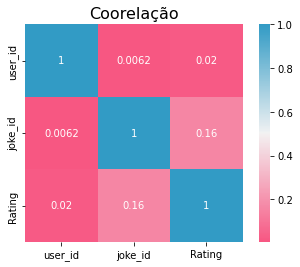

In [7]:
# Correlation of variables
cmap = sb.diverging_palette(0, 230, 90, 60, as_cmap=True)
sb.heatmap(train.corr(), annot=True, cmap=cmap, square=True)
plt.title("Coorelação", fontsize=16)
plt.show()

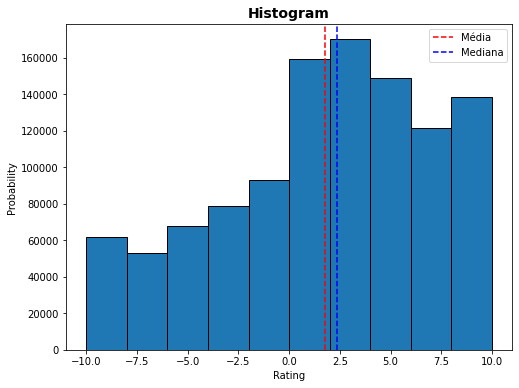

In [8]:
plt.figure(figsize=(8, 6))
plt.xlabel("Rating")
plt.ylabel("Probability")
plt.title("Histogram", fontweight="bold", fontsize=14)
plt.hist(train.Rating, edgecolor="black")
plt.axvline(train.Rating.mean(), color="red", linestyle="--")
plt.axvline(train.Rating.median(), color="blue", linestyle="--")
plt.legend(title="", labels=["Média","Mediana"], ncol=1, loc="best")
plt.show()

## Data Pre-Processing

In [3]:
# Removendo caracter e convertendo feature
train["id"] = train["id"].apply(lambda x: str(x).replace(str("_"), "")).astype("int64")
test["id"] = test["id"].apply(lambda x: str(x).replace(str("_"), "")).astype("int64")

In [4]:
train.head()

,id,user_id,joke_id,Rating
0,31030110,31030,110,2.750
1,16144109,16144,109,5.094
2,230986,23098,6,-6.438
3,1427386,14273,86,4.406
4,18419134,18419,134,9.375


### Split

In [4]:
X = train.drop(["Rating"], axis=1)
y = train.Rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=2)

### Scaling

In [5]:
scaling = MinMaxScaler()
X_train = scaling.fit_transform(X_train)
X_test = scaling.transform(X_test)

test = scaling.transform(test)

In [ ]:
#scaling = MinMaxScaler()
#for col in X_train.columns:
#    X_train[col] = scaling.fit_transform(X_train[[col]])
#    X_test[col] = scaling.transform(X_test[[col]])
#
#for col in test.columns:
#    test[col] = scaling.transform(test[[col]])

In [6]:
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [7]:
y_train = scaling.fit_transform(y_train)[:, 0]
y_test = scaling.fit_transform(y_test)[:, 0]

## Models

### Linear Regression

In [9]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

LinearRegression()

In [10]:
# Interceptação, inclinação e residuais
print(model.intercept_)
print(model.coef_)
print(model._residues)

[0.50168167]
[[-0.07413231  0.04148836  0.1701418 ]]
[50841.68775004]


In [11]:
y_pred1 = model.predict(X_test)
y_pred1

array([[0.56178664],
       [0.60708187],
       [0.51050616],
       ...,
       [0.63173133],
       [0.63676746],
       [0.54009885]])

In [15]:
mean_squared_error(y_test, y_pred1, squared=False)

0.2575344634379528

In [16]:
mean_squared_error(scaling.inverse_transform(y_test), scaling.inverse_transform(y_pred1), squared=False)

5.150689268759057

### SVR

In [8]:
regressor = SVR(kernel='rbf')
regressor.fit(X_train, y_train)

### XGBoost

In [24]:
def bay_opt(params):
    n_estimators=params[0]
    learning_rate=params[1]
    max_depth=params[2]
    min_child_weight=params[3]
    subsample=params[4]
    colsample_bynode=params[5]

    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, 
                    min_child_weight=min_child_weight, subsample=subsample, colsample_bynode=colsample_bynode, random_state=1)

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = model.predict(X_test)
    result = mean_squared_error(y_test, y_pred, squared=False)

    return result

In [ ]:
pbounds = [
    (500, 3500), # n_estimators
    (1.00e-04, 5.00e-01, 'log-uniform'), # learning_rate
    (2, 16), # max_depth
    (1, 6), # min_child_weight
    (0.01, 0.9), # subsample
    (0.01, 0.9) # colsample_bynode
]

In [26]:
res = gp_minimize(bay_opt, pbounds, verbose=1, n_calls=8, n_random_starts=2)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 235.2951
Function value obtained: 5.1652
Current minimum: 5.1652
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 728.1314
Function value obtained: 4.8617
Current minimum: 4.8617
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 596.5683
Function value obtained: 4.7362
Current minimum: 4.7362
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 323.5546
Function value obtained: 5.0318
Current minimum: 4.7362
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 611.1759
Function value obtained: 4.7867
Current minim

In [ ]:
plot_convergence(res)

In [34]:
#
model2 = XGBRegressor(
    random_state=0,
    n_estimators=2200,
    learning_rate=0.3,
    max_depth=8,
    min_child_weight=3,
    #subsample=,
    #num_parallel_tree=
)

#
model2.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=2200,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [35]:
y_pred2 = model2.predict(X_test)
mean_squared_error(y_test, y_pred2, squared=False)

4.465095631622332

4.8731787087578375
4.829584306803429
4.754165643844885
4.710329662520155
4.679860073940723
4.616868239833476
4.577720177672937
4.554786158095966
4.53884936597744
4.521754976656402 - 1400
4.504470750294035 - 1800
4.492497361633984 - 2200
4.480416479316659 -
4.468527574175462 - 2
4.4628466701085685 - 3

## Submission

In [33]:
submit_id = pd.read_csv("dados/test.csv")["id"]
submit = pd.DataFrame({"id": submit_id, "Rating": abs(model2.predict(test))}, columns=["id", "Rating"])
submit.to_csv("submission.csv", index=False)
submit.head()

,id,Rating
0,6194_11,3.710104
1,19356_3,0.379057
2,23426_79,0.550185
3,40030_3,3.956149
4,19806_115,4.530601
